## Setup

In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
import glob
from pathlib import Path
import json
import gradio as gr
import os
from PIL import Image, ImageDraw
import threading
import matplotlib.pyplot as plt
from IPython.display import Image, display



# Download the images
def in_colab() -> bool:
    try:
        import google.colab
        return True
    except Exception:
        return False

REPO_URL = "https://github.com/Tiromachelan/camera-pose-estimator"

if in_colab():
  if not Path("camera-pose-estimator/images").exists():
    !git clone {REPO_URL}
    !pip install pytransform3d

import pytransform3d.transformations as pt
import pytransform3d.camera as pc


## Calibration

In [2]:
class Calibration:
    @staticmethod
    def calibrateCamera(image_files):
        print(f"calibrating data in folder {image_files}")
        # termination criteria
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        pattern_size = (9, 6)
        objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
        objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d point in real world space
        imgpoints = [] # 2d points in image plane.

        images = glob.glob(image_files + '/*.jpeg')

        gray = None
        for fname in images:
            img = cv.imread(fname)
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            #print(f"{'processing image '}{fname}")

            # Find the chess board corners
            ret, corners = cv.findChessboardCorners(gray, pattern_size, None)

            # If found, add object points, image points (after refining them)
            if ret == True:
                print(f"{"Processed "}{fname}")
                objpoints.append(objp)

                corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
                imgpoints.append(corners2)
        return(cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None))

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def calibrate_and_display(folder_path):
    ret, mtx, dist, rvecs, tvecs = Calibration.calibrateCamera(folder_path)

    files = glob.glob(os.path.join(folder_path, "*.jpeg")) + glob.glob(os.path.join(folder_path, "*.JPEG"))

    results = {
        "return_value": ret,
        "camera_matrix": mtx,
        "distortion_coefficients": dist,
        "rotation_vectors": rvecs,
        "translation_vectors": tvecs,
        "image_paths": files
    }
    json_output = json.dumps(results, cls=NumpyEncoder, indent=4)

    with open("calibration.json", "w") as f:
        f.write(json_output)

    return json_output

if in_colab():
    calibrate_and_display("camera-pose-estimator/images")
else:
    calibrate_and_display("images")

calibrating data in folder images
Processed images/DSCN0504.jpeg
Processed images/DSCN0494.jpeg
Processed images/DSCN0498.jpeg
Processed images/DSCN0499.jpeg
Processed images/DSCN0495.jpeg
Processed images/DSCN0483.jpeg
Processed images/DSCN0488.jpeg
Processed images/DSCN0502.jpeg
Processed images/DSCN0484.jpeg
Processed images/DSCN0492.jpeg
Processed images/DSCN0493.jpeg
Processed images/DSCN0485.jpeg
Processed images/DSCN0503.jpeg
Processed images/DSCN0489.jpeg
Processed images/DSCN0490.jpeg
Processed images/DSCN0486.jpeg
Processed images/DSCN0501.jpeg
Processed images/DSCN0487.jpeg
Processed images/DSCN0496.jpeg
Processed images/DSCN0497.jpeg


In [3]:
class calib:
  @staticmethod
  def load_calibration(jsonPath:str='calibration.json'):
    with open(jsonPath, 'r') as file:
            calibrationDict = json.load(file)
    #extracting k and distance coefficientse
    k = calibrationDict['camera_matrix']
    distanceCoeff = calibrationDict['distortion_coefficients']
    return k, distanceCoeff


# Homography --> Pose (Explicit)

# OpenCV Solution

In [4]:
# Use cv.solvePnP to estimate pose from picked points
def estimate_pose_opencv():
    # Read selected points from json
    with open('selected_points.json', 'r') as f:
        selected_points = json.load(f)
    image_points = np.array(selected_points, dtype=np.float32)
    #print(f"selected_points: {selected_points}")

    # Read camera matrix and distortion coefficients from json
    with open('calibration.json', 'r') as f:
        calib_data = json.load(f)
    camera_matrix = np.array(calib_data['camera_matrix'], dtype=np.float32)
    dist_coeffs = np.array(calib_data['distortion_coefficients'], dtype=np.float32)
    #print(f"camera_matrix: {camera_matrix}")
    #print(f"dist_coeffs: {dist_coeffs}")

    # Calculate the model points, using pixels as units
    model_points = np.array([[x, y, 0] for x, y in selected_points], dtype=np.float32) # Divide by 300 to scale it down
    model_points = np.array(model_points, dtype=np.float32)

    # Solve PnP
    success, rotation_vector, translation_vector = cv.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)
    if not success:
        raise RuntimeError("Failed to solve PnP")
    return rotation_vector, translation_vector

# For testing purposes
#estimate_pose_opencv()


# Gradio Picker code

In [5]:

def launch_point_picker(my_image):
    points_store = []
    app = None
    SELECTED_POINTS = None

    def _to_pil_from_numpy(arr: np.ndarray) -> Image.Image:
        arr = np.asarray(arr)
        # channel-first -> channel-last
        if arr.ndim == 3 and arr.shape[0] in (1,3,4) and arr.shape[-1] not in (1,3,4):
            arr = np.transpose(arr, (1,2,0))
        if np.issubdtype(arr.dtype, np.floating):
            # scale floats in [0,1] to [0,255]
            arr = (np.clip(arr, 0.0, 1.0) * 255.0).round().astype(np.uint8)
        elif arr.dtype != np.uint8:
            arr = np.clip(arr, 0, 255).astype(np.uint8)
        # Choose mode
        if arr.ndim == 2:
            return Image.fromarray(arr, mode="L")
        if arr.ndim == 3 and arr.shape[2] == 3:
            return Image.fromarray(arr, mode="RGB")
        if arr.ndim == 3 and arr.shape[2] == 4:
            return Image.fromarray(arr, mode="RGBA")
        if arr.ndim == 3 and arr.shape[2] == 1:
            return Image.fromarray(arr[:,:,0], mode="L")
        raise ValueError(f"Unsupported array shape: {arr.shape}")

    def _to_pil(img):
        if isinstance(img, Image.Image):
            return img
        if isinstance(img, np.ndarray):
            return _to_pil_from_numpy(img)
        raise gr.Error("Set `my_image` to a PIL image or NumPy array before launching.")

    def _draw_points(base_img: Image.Image, pts, radius=5):
        img = base_img.copy().convert("RGB")
        d = ImageDraw.Draw(img)
        for (x, y) in pts:
            d.ellipse([x-radius, y-radius, x+radius, y+radius], outline=(255,0,0), width=2)
        return img

    # Prepare base image from notebook variable
    # if 'my_image' not in globals():
        # raise RuntimeError("Please define `my_image` (PIL image or NumPy array) before running this cell.")
    # base_pil = _to_pil(globals()['my_image'])
    base_pil = _to_pil(my_image)

    def _refresh_numpy():
        """Return current preview (base + points) as numpy for Gradio."""
        return np.array(_draw_points(base_pil, points_store))

    def on_click(evt: gr.SelectData):
        # Get coordinates robustly
        x = y = None
        if hasattr(evt, "index") and evt.index is not None:
            try: x, y = evt.index
            except: pass
        if (x is None or y is None) and hasattr(evt, "x") and hasattr(evt, "y"):
            x, y = evt.x, evt.y
        if x is None or y is None:
            return gr.update(), json.dumps(points_store)

        # Clamp to image bounds
        w, h = base_pil.size
        x = int(max(0, min(w-1, x)))
        y = int(max(0, min(h-1, y)))

        points_store.append([x, y])
        return _refresh_numpy(), json.dumps(points_store)

    def undo_last():
        if points_store:
            points_store.pop()
        return _refresh_numpy(), json.dumps(points_store)

    def clear_points():
        points_store.clear()
        return np.array(base_pil), "[]"

    def done_btn_click():
        """Save to notebook var `selected_points` and close the app."""
        global SELECTED_POINTS
        SELECTED_POINTS = [list(p) for p in points_store]
        try:
            ip = get_ipython()
            if ip is not None:
                ip.user_ns['selected_points'] = SELECTED_POINTS
        except Exception:
            pass
        # threading.Thread(target=lambda: app.close(), daemon=True).start()
        with open('selected_points.json', 'w') as f:
            json.dump(SELECTED_POINTS, f)

        # Use OpenCV to calculate camera pose
        rotation_vector, translation_vector = estimate_pose_opencv()

        # Plot the cameras
        Visualizer.visualize(rotation_vector, translation_vector)
        return f"✅ Saved {len(SELECTED_POINTS)} points to `selected_points`. Closing…"


    with gr.Blocks(title="Point Picker (single image)") as demo:
        gr.Markdown("**Click on the image to add points.** Use Undo / Clear as needed, then press **Done**.")
        img = gr.Image(
            value=np.array(base_pil), label="Image (click to add points)",
            type="numpy", interactive=True, sources=[]  # sources=[] disables uploads
        )
        with gr.Row():
            undo_btn = gr.Button("↩️ Undo")
            clear_btn = gr.Button("🧹 Clear")
            done_btn = gr.Button("✅ Done", variant="primary")
        pts_text = gr.Textbox(label="Points (JSON)", value="[]", interactive=False)
        status = gr.Markdown("")

        # One image used for both input and output
        img.select(on_click, inputs=None, outputs=[img, pts_text])
        undo_btn.click(lambda: undo_last(), outputs=[img, pts_text])
        clear_btn.click(lambda: clear_points(), outputs=[img, pts_text])
        done_btn.click(done_btn_click, outputs=[status])


        app = demo.launch(inline=True, prevent_thread_lock=True)
        return app

# Launch Gradio Interface

In [6]:
# my_image can be a PIL.Image or a NumPy array (H,W[,C])
from PIL import Image
if in_colab():
    my_image = Image.open("camera-pose-estimator" + "/" + "DSCN0851.JPG")
else:
    my_image = Image.open("DSCN0851.JPG")

selected_points = []

app = launch_point_picker(my_image)   # launches inline, non-blocking

# ... later, after clicking points and pressing "Done":
print(selected_points)  # list of [x, y] pixel coordinates


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


[]


In [9]:
print(selected_points)

[[1697, 741], [2797, 832], [3333, 3030], [1374, 3053]]


# Display the 3D plot
### For some reason this will not display after clicking "Done" in gradio, so run this cell instead

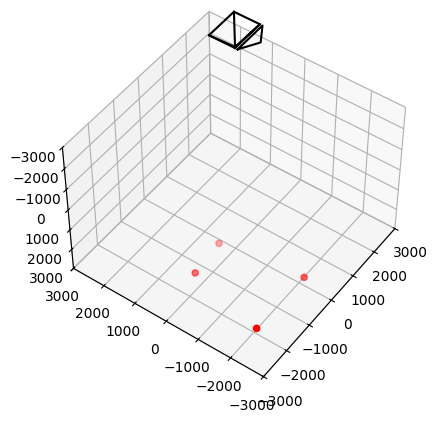

Rotation Vector: [[-5.68738878e-03]
 [-8.93345067e-04]
 [ 5.74693986e-07]]
Translation Vector: [[-2283.55722982]
 [-1640.50268262]
 [ 3051.64628952]]


In [15]:
class Visualizer:
    def visualize(rotation_vector, translation_vector):
        sensor_size = (4608, 3456) # maybe change this in case the images are different sizes?
        virtual_image_distance = .8
        with open("calibration.json", "r") as file:
            views = json.load(file)

        Lambda = np.array(views.get("camera_matrix")).reshape(3,3)
        Omega = np.array(rotation_vector)
        tau = np.array(translation_vector)
        dist = np.array(views.get("distortion_coefficients"))

        # Convert to a rotation matrix from a vector
        Omega, _ = cv.Rodrigues(Omega)

        # Camera pose, i.e., the matrix [R t] of extrinsic parameters
        Rt = np.block([Omega.T, -Omega.T @ tau.reshape(3, 1)])

        # Convert Rt from 3x4 to a 4x4 transformation matrix
        Rt = np.vstack([Rt, [0, 0, 0, 1]])

        cam2world = Rt
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Increased the size of the plotted camera pose
        #ax = pt.plot_transform(ax=ax, A2B=cam2world, s=500)
        scale = 30  # increase to make the plotted camera bigger
        pc.plot_camera(
            ax,
            cam2world=cam2world,
            M=Lambda,
            sensor_size=(int(sensor_size[0]*scale), int(sensor_size[1]*scale)),
            virtual_image_distance=virtual_image_distance * scale,
        )

        # plot points selected
        points_2d = selected_points
        points_3d = []
        for point_2d in points_2d:
            # Convert 2D image points to 3D points on the plane (z=0 in world coordinates)
            # This is a simplified approach assuming the points are on the ground plane (z=0)
            # More complex scenarios might require additional information or techniques.
            # Convert to homogeneous coordinates
            point_hom = np.array([point_2d[0], point_2d[1], 1.0])
            # Invert the camera matrix
            Lambda_inv = np.linalg.inv(Lambda)
            # Point in camera coordinates (up to a scale factor)
            point_cam = Lambda_inv @ point_hom
            # Point in world coordinates (on the plane z=0)
            # We need to find a scale factor alpha such that alpha * R.T @ point_cam + t is on the z=0 plane
            # Let the point in world coordinates be Pw = [Xw, Yw, Zw]. We want Zw = 0
            # Pw = R.T @ (alpha * point_cam) + t
            # Pw = alpha * R.T @ point_cam + t
            # Let R.T @ point_cam = [rx, ry, rz] and t = [tx, ty, tz]
            # Zw = alpha * rz + tz = 0
            # alpha = -tz / rz
            R_inv = Omega.T
            t = tau.reshape(3, 1)
            point_cam_reshaped = point_cam.reshape(3, 1)
            RT_point_cam = R_inv @ point_cam_reshaped
            if RT_point_cam[2, 0] != 0:
                alpha = -t[2, 0] / RT_point_cam[2, 0]
                point_world = alpha * RT_point_cam + t
                points_3d.append(point_world[:3, 0]) # Append only the x, y, z coordinates

        points_3d = np.array(points_3d)

        # Include the camera translation vector in the points for limit calculation
        all_points = np.vstack((points_3d, tau.reshape(1, 3)))

        if len(all_points) > 0:
            if len(points_3d) > 0:
                 ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='r', marker='o')


            # Calculate limits based on all points (including camera translation)
            max_range = np.array([all_points[:,0].max()-all_points[:,0].min(),
                                  all_points[:,1].max()-all_points[:,1].min(),
                                  all_points[:,2].max()-all_points[:,2].min()]).max() / 2.0

            mid_x = (all_points[:,0].max()+all_points[:,0].min()) * 0.5
            mid_y = (all_points[:,1].max()+all_points[:,1].min()) * 0.5
            mid_z = (all_points[:,2].max()+all_points[:,2].min()) * 0.5

            spaceSize = 3000

            ax.set_xlim(-spaceSize, spaceSize)
            ax.set_ylim(-spaceSize, spaceSize)
            ax.set_zlim(-spaceSize, spaceSize)

            # Set initial view based on translation vector
            # The elev and azim angles are in degrees
            elev = np.arctan2(tau[2,0], np.sqrt(tau[0,0]**2 + tau[1,0]**2)) * 180/np.pi
            azim = np.arctan2(tau[1,0], tau[0,0]) * 180/np.pi
            ax.view_init(elev=elev, azim=azim)


        ax.invert_zaxis() # It looks upside down without this
        #plt.savefig("pose_plot.png")
        #display(Image(filename="pose_plot.png"))


        plt.show()
        print(f"Rotation Vector: {rotation_vector}")
        print(f"Translation Vector: {translation_vector}")

rotation_vector, translation_vector = estimate_pose_opencv()
Visualizer.visualize(rotation_vector, translation_vector)